In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("../..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
import jax_smi
jax_smi.initialise_tracking()
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True, device_map="tpu:0")

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [5]:
from sprint.icl_sfc_utils import Circuitizer

In [6]:
from sprint.task_vector_utils import load_tasks, ICLRunner
tasks = load_tasks()

fatal: destination path 'data/itv' already exists and is not an empty directory.


In [7]:
task_names = ["en_es", "antonyms", "person_profession"]
task_name = task_names[0]
task_name = "antonyms"

In [8]:
import json

with open("cleanup_results.jsonl") as f:
    lines = f.readlines()
    results = [json.loads(line) for line in lines]

In [9]:
def check_if_single_token(token):
    return len(tokenizer.tokenize(token)) == 1

task = tasks[task_name]

print(len(task))

# task = {
#     k:v for k,v in task.items() if check_if_single_token(k) and check_if_single_token(v)
# }

print(len(task))

pairs = list(task.items())

batch_size = 8 
n_shot=8
if task_name.startswith("algo"):
    n_shot = 8
max_seq_len = 128
seed = 10

prompt = "Follow the pattern:\n{}"

runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed, prompt=prompt)


layers = list(range(3, 17))
circuitizer = Circuitizer(llama, tokenizer, runner, layers, prompt)

162
162
Setting up masks...


Running metrics...
Setting up RMS...


  0%|          | 0/18 [00:00<?, ?it/s]

Loading SAEs...


  0%|          | 0/14 [00:00<?, ?it/s]

Running node IEs...


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [10]:
second_task_name = task_names[0]

second_task = tasks[second_task_name]

second_task = {
    k:v for k,v in second_task.items() if check_if_single_token(k) and check_if_single_token(v)
}

second_pairs = list(second_task.items())

second_runner = ICLRunner(second_task_name, second_pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

In [55]:
import numpy as np
# thresholds = np.linspace(-1e-2, 1e-4, 200)
thresholds = np.logspace(-6, -2, 300)
topks = [4, 6, 12, 16, 24, 32]


ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics(thresholds, inverse=False, do_abs=False, mean_ablate=False, layers=[11, 12, 13, 14])


# target_metric = (max(ablated_metrics) - min(ablated_metrics)) * 0.95 + min(ablated_metrics)
# target_threshold = [threshold for threshold, metric in reversed(list(zip(thresholds, ablated_metrics))) if metric > target_metric][0]

  0%|          | 0/300 [00:00<?, ?it/s]

In [56]:
target_metric = (max(ablated_metrics) - min(ablated_metrics)) * 0.95 + min(ablated_metrics)

print(target_metric)
target_threshold = [threshold for threshold, metric in reversed(list(zip(thresholds, ablated_metrics))) if metric > target_metric][0]
print(target_threshold)

-2.098437500000001
8.638828442740453e-06


[<matplotlib.lines.Line2D at 0x7ed2a0646ce0>]

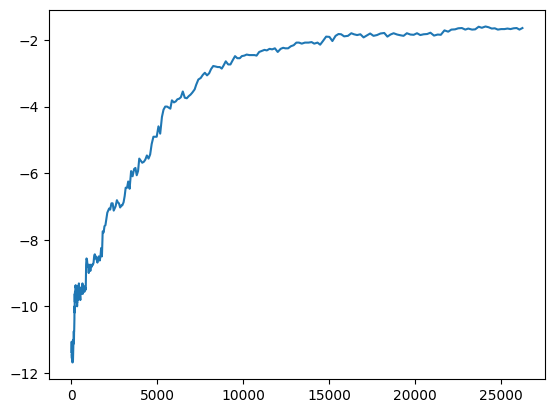

In [57]:
import matplotlib.pyplot as plt

# plt.plot([max(n_nodes_counts) - x for x in n_nodes_counts], ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
plt.plot(n_nodes_counts, ablated_metrics)
# plt.plot(thresholds, n_nodes_counts)
# plt.xscale("log")

[<matplotlib.lines.Line2D at 0x7f8c737d7d00>]

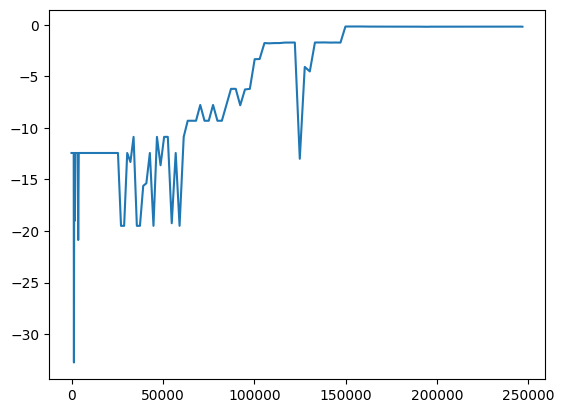

In [18]:
import matplotlib.pyplot as plt

# plt.plot([max(n_nodes_counts) - x for x in n_nodes_counts], ablated_metrics)
# plt.plot(thresholds, ablated_metrics)
plt.plot(n_nodes_counts, ablated_metrics)
# plt.plot(n_nodes_counts, ablated_metrics)
# plt.xscale("log")

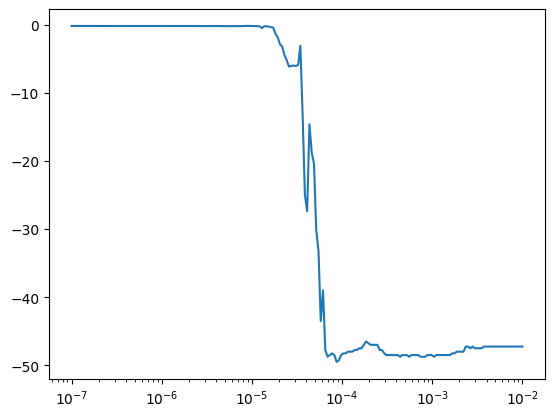

In [23]:
import matplotlib.pyplot as plt

# plt.plot([max(n_nodes_counts) - x for x in n_nodes_counts], ablated_metrics)
plt.plot(thresholds, ablated_metrics)
# plt.plot(n_nodes_counts, ablated_metrics)
# plt.plot(n_nodes_counts, ablated_metrics)
plt.xscale("log")

In [23]:
mask[0]

# jax.Array bool(127,) true:59 false:68
  Array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True], dtype=bool)

In [27]:
max(ablated_metrics), min(ablated_metrics)

(-4.625, -780.0)

In [26]:
circuitizer.ablated_metric(llama)

<jax.Array(-5.46875, dtype=bfloat16)>

In [ ]:
from tqdm.auto import tqdm

ams = []

for layer in tqdm(circuitizer.layers):
    ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics(thresholds, inverse=True, sae_types=["attn_out"], layers=[layer])
    ams.append(ablated_metrics)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
[min(x) for x in ams]

[-1.609375,
 -1.5234375,
 -1.5234375,
 -1.5390625,
 -1.5859375,
 -1.6484375,
 -1.75,
 -3.28125,
 -1.5390625,
 -1.6328125,
 -1.546875]

: 

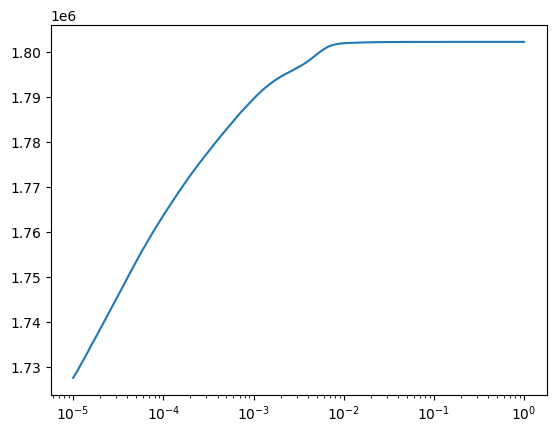

In [ ]:
plt.plot(thresholds, n_nodes_counts)
plt.xscale("log")

In [ ]:
ablated_metrics[22]

-5.25

In [26]:
from tqdm.auto import tqdm

layers = circuitizer.layers
selected_threshold = target_threshold


ablation_masks = {}

for layer in tqdm(layers):
    mask_attn_out, _ = circuitizer.mask_ie(circuitizer.ie_attn[layer], selected_threshold, None, do_abs=True)
    mask_resid, _ = circuitizer.mask_ie(circuitizer.ie_resid[layer], selected_threshold, None, do_abs=True)
    try:
        mask_transcoder, _ = circuitizer.mask_ie(circuitizer.ie_transcoder[layer], selected_threshold, None, do_abs=True)
    except KeyError:
        mask_transcoder = None

    ablation_masks[layer] = {
        "attn_out": mask_attn_out,
        "resid": mask_resid,
        "transcoder": mask_transcoder
    }

  0%|          | 0/14 [00:00<?, ?it/s]

In [27]:
ablated_nodes = []
n_nodes = 0

for layer, masks in ablation_masks.items():
    for mask_type, mask in masks.items():
        if mask is not None:
            for token_type, mask in mask.items():
                    deleted = (1 - mask)
                    n_nodes += mask.sum()
                    # 1/0
                    node_ids = np.where(deleted)[0]

                    for node_id in node_ids:
                        ablated_nodes.append((layer, mask_type, token_type, node_id))

n_nodes

<jax.Array(8572, dtype=int32)>

In [ ]:
typed_ies = {
    "r": circuitizer.ie_resid,
    "a": circuitizer.ie_attn,
    "t": circuitizer.ie_transcoder,
}

for node in ablated_nodes:
    layer, sae_type, token_type, node_id = node
    ies = typed_ies[sae_type[0]][layer]
    masked_ies = circuitizer.mask_average(ies, token_type)
    print(node, masked_ies[node_id])


(6, 'resid', 'prompt', 9739) -0.0071461396
(6, 'resid', 'arrow', 27871) -0.0084896125
(6, 'resid', 'output', 26865) -0.01059139
(6, 'resid', 'newline', 27329) 0.00815366
(7, 'resid', 'arrow', 16810) -0.0073989355
(7, 'resid', 'output', 4550) -0.0069641653
(7, 'resid', 'output', 10864) -0.011371329
(8, 'resid', 'output', 9583) -0.012012116
(8, 'resid', 'output', 15542) -0.008059898
(9, 'attn_out', 'output', 7893) 0.008108275
(9, 'resid', 'arrow', 2758) 0.0069937613
(9, 'resid', 'arrow', 4349) 0.0109015275
(9, 'resid', 'output', 8034) -0.008602059
(9, 'resid', 'output', 8732) -0.008685451
(9, 'resid', 'output', 23618) -0.01118652
(9, 'resid', 'output', 31550) -0.010838249
(10, 'attn_out', 'output', 11888) 0.0110707525
(10, 'resid', 'arrow', 4234) -0.008054613
(10, 'transcoder', 'output', 1155) -0.009782738
(10, 'transcoder', 'output', 18384) 0.017217372
(10, 'transcoder', 'output', 27768) -0.007970517
(11, 'attn_out', 'arrow', 11854) 0.015281908
(11, 'attn_out', 'arrow', 11927) 0.0172595

: 

In [ ]:
len(ablated_nodes)

206

In [ ]:
removed_features_attn_mask = mask_attn_out_2["arrow"].astype(np.int32) -  mask_attn_out_1["arrow"].astype(np.int32)
removed_features_attn_mask = removed_features_attn_mask == 1

In [ ]:
removed_features_attn_mask.sum()

<jax.Array(57, dtype=int32)>

In [ ]:
removed_features_attn = circuitizer.saes[(12, "resid")]["W_dec"][removed_features_attn_mask]

In [ ]:
removed_features_attn = removed_features_attn / np.linalg.norm(removed_features_attn, axis=1, keepdims=True)

pairwise_sims = removed_features_attn @ removed_features_attn.T



In [ ]:
%pip install -U kaleido

/usr/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 14.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import plotly.express as px
import plotly.io as pio

fig = px.imshow(pairwise_sims, width=800, height=800)
# pio.write_image(fig, "pairwise_sims.png")

fig

In [ ]:
features = [9790, 12605, 13458, 11491, 18803, 2931, 11618, 26987, 5679, 15554, 26594]

In [ ]:
from sprint.icl_sfc_utils import AblatedModule
layer = 12
mask_name = "arrow"

In [ ]:
task_results = [result for result in results if result["task"] == task_name]

In [ ]:
len(task_results)

8

In [ ]:
import jax.numpy as jnp

layer_masks = {}

resid = circuitizer.saes[(12, "resid")]


for r in task_results:
    layer = r["layer"]
    w = np.array(r["weights"])
    f_ids = jnp.nonzero(w * (w > 0))

    feature = features[0]

    mask = np.ones(resid["W_dec"].shape[0])
    mask[f_ids] = 0

    mask = jnp.array(mask)

    masks = {
        k: mask for k in circuitizer.masks
    }

    # masks[mask_name] = mask

    layer_masks[layer] = masks



In [ ]:
from micrlhf.llama import LlamaBlock

llama_ablated = llama

for layer, masks in layer_masks.items():
    block_selection = llama_ablated.select().at_instances_of(LlamaBlock).pick_nth_selected(layer)

    def converter(block):
        block = block.select().at_instances_of(LlamaBlock).apply(lambda x: pz.nn.Sequential([AblatedModule.wrap(resid, masks, circuitizer.masks), x]))    
        return block

    llama_ablated = block_selection.apply(converter)

In [ ]:
print(circuitizer.ablated_metric(llama_ablated))
print(circuitizer.ablated_metric(llama))

-1.6610659
-1.40625


In [ ]:
circuitizer.run_ablated_metrics([-1, 0, target_threshold])

  0%|          | 0/3 [00:00<?, ?it/s]

([-1.3984375, -1.4296875, -1.0703125], [5242880, 200719, 118202])

In [ ]:
import matplotlib.pyplot as plt

ablated_metrics[:40]

[-1.2734375,
 -1.28125,
 -1.2578125,
 -1.265625,
 -1.171875,
 -1.078125,
 -1.1015625,
 -1.1328125,
 -1.078125,
 -1.1015625,
 -1.1796875,
 -1.171875,
 -1.1953125,
 -1.2109375,
 -1.1875,
 -1.1875,
 -1.1875,
 -1.1796875,
 -1.15625,
 -1.0546875,
 -1.0546875,
 -1.046875,
 -1.078125,
 -1.1328125,
 -1.09375,
 -1.0625,
 -1.1171875,
 -1.140625,
 -1.1015625,
 -1.140625,
 -1.1171875,
 -1.1796875,
 -1.25,
 -1.171875,
 -1.140625,
 -1.09375,
 -1.0078125,
 -1.03125,
 -1.1015625,
 -1.1015625]

In [ ]:
logits = llama(circuitizer.llama_inputs)

In [ ]:
logits = logits.unwrap("batch", "seq", "vocabulary")

In [ ]:
logits = logits.argmax(-1)

In [ ]:
logits = logits[:, :-1]

res = logits == circuitizer.train_tokens[:, 1:]

In [ ]:
answer_mask = circuitizer.train_tokens[:, 1:] == 3978
answer_mask = np.roll(answer_mask, 1, axis=1)

In [ ]:
(res * answer_mask).sum() / answer_mask.sum()

<jax.Array(0.7265625, dtype=float32)>